In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import scanpy.api as sc
from anndata import read_h5ad
from anndata import AnnData
import scipy as sp
import scipy.stats
from gprofiler import GProfiler
import pickle
from adjustText import adjust_text
from matplotlib import gridspec
# Other specific functions 
from itertools import product
from statsmodels.stats.multitest import multipletests
import util

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

/home/martin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


scanpy==1.4.3 anndata==0.6.20 umap==0.3.8 numpy==1.16.4 scipy==1.2.1 pandas==0.25.0 scikit-learn==0.21.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Load data

In [2]:
data_path = '/data3/martin/tms_gene_data'
anno_data_folder = data_path + '/annotation_data'
DE_result_path = data_path + '/DE_result'
output_folder_fig = data_path + '/results/tms_gene_figure'
output_folder_tab = data_path + '/results/tms_gene_table'

In [3]:
# Load the data 
adata_combine = util.load_normalized_data(data_path)
adata_bulk = util.load_normalized_data_bulk(data_path)

Trying to set attribute `.obs` of view, making a copy.


In [4]:
temp_facs = adata_combine[adata_combine.obs['b_method']=='facs',]
temp_droplet = adata_combine[adata_combine.obs['b_method']=='droplet',]
temp_bulk = adata_bulk.copy()

In [5]:
# change tissue name for bulk
tissue_name_change_dic = {'Brown_Fat':'BAT', 
                          'Gonadal_Fat':'GAT',
                          'Mesenteric_Fat':'MAT',
                          'Subcutaneous_Fat':'SCAT'}
temp_tissue = temp_bulk.obs['tissue'].astype(str)
for tissue in tissue_name_change_dic.keys():
    temp_tissue[temp_tissue==tissue] = tissue_name_change_dic[tissue]
temp_bulk.obs['tissue'] = temp_tissue.astype('category')

### Load DE results, age, tissue

In [6]:
# Load DE result
with open(DE_result_path+'/DE_tissue_FACS.pickle', 'rb') as handle:
    DE_result_MAST = pickle.load(handle)
    analysis_list = pickle.load(handle)
    analysis_info = pickle.load(handle)
with open(DE_result_path+'/DE_tissue_droplet.pickle', 'rb') as handle:
    DE_result_MAST_droplet = pickle.load(handle)
    analysis_list_droplet = pickle.load(handle)
    analysis_info_droplet = pickle.load(handle)

In [7]:
with open(DE_result_path+'/DE_bulk.pickle', 'rb') as handle:
    temp_dic = pickle.load(handle)
    analysis_list_bulk = pickle.load(handle)
    analysis_info_bulk = pickle.load(handle)
# Take only the overlapping genes and recompute the p-value
gene_list = list(adata_combine.var_names)
DE_result_MAST_bulk = {}
for tissue in temp_dic.keys():
    DE_result_MAST_bulk[tissue] = pd.DataFrame(index = gene_list)
    DE_result_MAST_bulk[tissue] = DE_result_MAST_bulk[tissue].join(temp_dic[tissue])
    # Recompute bh-p based on a small subset of p-values 
    ind_select = ~np.isnan(DE_result_MAST_bulk[tissue]['raw-p'])
    DE_result_MAST_bulk[tissue].loc[ind_select, ['bh-p']] = \
        multipletests(DE_result_MAST_bulk[tissue]['raw-p'][ind_select], method='fdr_bh')[1]
    if tissue in tissue_name_change_dic.keys():
        DE_result_MAST_bulk[tissue_name_change_dic[tissue]] = DE_result_MAST_bulk[tissue]
        del DE_result_MAST_bulk[tissue]

In [8]:
dic_DE_result = {'FACS':DE_result_MAST, 'droplet':DE_result_MAST_droplet,
                 'bulk':DE_result_MAST_bulk}
dic_data = {'FACS':temp_facs, 'droplet':temp_droplet, 'bulk':temp_bulk}

In [9]:
coef_threshold = 0.005
# fc_threshold = 0.01

In [10]:
comparison_list = ['FACS;droplet', 'FACS;bulk', 'bulk;droplet']
method_list = ['FACS', 'droplet', 'bulk']
dic_analysis_list = {x:list(set(dic_DE_result[x])) for x in method_list}
dic_fdr_threshold = {x:0.1 if x=='bulk' else 0.01 for x in method_list}

### Summarizing number of discoveries

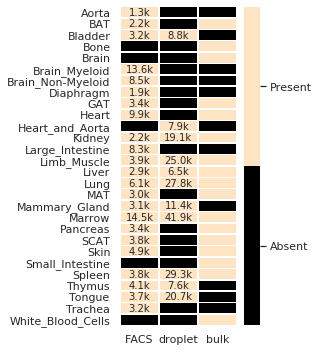

In [11]:
from matplotlib.colors import LinearSegmentedColormap
analysis_list_total = list(set(dic_analysis_list['FACS']) | 
                           set(dic_analysis_list['droplet']) | 
                           set(dic_analysis_list['bulk'])) 
analysis_list_total.sort()
temp_df = pd.DataFrame(index=analysis_list_total)
temp_df_ct = pd.DataFrame(index=analysis_list_total)
for method in method_list:
    temp_df[method] = [True if x in dic_analysis_list[method] else False 
                       for x in analysis_list_total]
    if method=='FACS':
        temp_df_ct[method] = [(temp_facs.obs['tissue']==x).sum() 
                              for x in analysis_list_total]
    elif method=='droplet':
        temp_df_ct[method] = [(temp_droplet.obs['tissue']==x).sum() 
                              for x in analysis_list_total]
    else:
        temp_df_ct[method] = [0 for x in analysis_list_total]
    temp_df_ct[method] = [ '' if x*y==0 else '%0.1fk'%(x/1000)
                          for x,y in zip(temp_df_ct[method], temp_df[method])]
# Heatmap
plt.figure(figsize = [4.5,5])
colors = ["black", "bisque"] 
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
ax = sns.heatmap(temp_df, cmap=cmap, yticklabels=True,
                 annot=temp_df_ct, fmt="s", linewidths=.5)
# Set the colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['Absent', 'Present'])
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.savefig(output_folder_fig + '/data_tissue.pdf', transparent=True)
plt.show()

In [12]:
# Visualize the number of discoveries
plot_list = dic_analysis_list['FACS']
plot_list.sort()
method = 'FACS'
temp_df = pd.DataFrame(index = plot_list)
temp_df['%s'%method] = [np.sum((dic_DE_result[method][x]['bh-p']<dic_fdr_threshold[method]) &
                        (np.absolute(dic_DE_result[method][x]['coef'])>coef_threshold))
                     for x in plot_list]
temp_df['up'] = [np.log10(np.sum((dic_DE_result[method][x]['bh-p']<dic_fdr_threshold[method]) &
                        ((dic_DE_result[method][x]['coef']>coef_threshold))))
                         for x in plot_list]
temp_df['down'] = [-np.log10(np.sum((dic_DE_result[method][x]['bh-p']<dic_fdr_threshold[method]) &
                            ((dic_DE_result[method][x]['coef']<-coef_threshold))))
                           for x in plot_list]    
temp_df['up/down'] = 10**(temp_df['up']+temp_df['down'])
temp_df['tissue'] = [x.split('.')[0] for x in temp_df.index]
temp_df['n_cell'] = [np.log10(np.sum(temp_facs.obs['tissue']==x)) for x in temp_df.index]
ind_select = temp_df['up']>np.absolute(temp_df['down'])
print('%d/%d up regulation'%(np.sum(ind_select),  temp_df.shape[0]))
temp_df.loc[ind_select]

3/23 up regulation


,FACS,up,down,up/down,tissue,n_cell
Aorta,1001,2.758912,-2.630428,1.344262,Aorta,3.126456
Large_Intestine,1171,2.902003,-2.571709,2.139410,Large_Intestine,3.919653
Spleen,1278,2.866878,-2.733999,1.357934,Spleen,3.583652


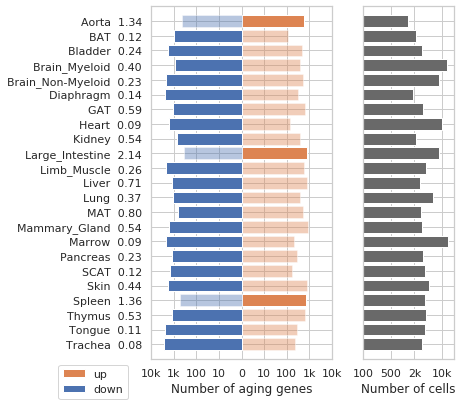

In [13]:
temp_plot_df = temp_df.copy()
temp_plot_df = temp_plot_df.iloc[::-1]
plt.figure(figsize=[6.5,0.25*temp_plot_df.shape[0]])
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
plt.subplot(gs[0])
ind_select = temp_plot_df['up']>np.absolute(temp_plot_df['down'])
plt.barh(np.arange(temp_plot_df.shape[0])[ind_select],
         temp_plot_df['up'][ind_select], label='up', color='C1')
plt.barh(np.arange(temp_plot_df.shape[0])[~ind_select],
         temp_plot_df['up'][~ind_select], alpha=0.4, color='C1')
plt.barh(np.arange(temp_plot_df.shape[0])[~ind_select],
         temp_plot_df['down'][~ind_select], label='down', color='C0')
plt.barh(np.arange(temp_plot_df.shape[0])[ind_select],
         temp_plot_df['down'][ind_select], alpha=0.4, color='C0')
x_tick = list(-np.log10([10000, 1000, 100, 10])) + [0] + \
                list(np.log10([10, 100, 1000, 10000])) 
plt.xticks(x_tick, ['10k', '1k', '100', '10', '0', '10', '100', '1k', '10k'])
temp_y_tick = ['%s  %0.2f'%(x,y) if len(x)>0 else x 
               for x,y in zip(temp_plot_df.index, temp_plot_df['up/down']) ]
plt.yticks(np.arange(temp_plot_df.shape[0]), temp_y_tick)
plt.ylim([-1, temp_plot_df.shape[0]])
plt.legend(bbox_to_anchor=(-0.1, 0))
plt.xlabel('Number of aging genes')

plt.subplot(gs[1])
plt.barh(np.arange(temp_plot_df.shape[0]), temp_plot_df['n_cell'], color='dimgray')
x_tick = np.log10([100, 500, 2000, 10000])
plt.xticks(x_tick, ['100', '500', '2k', '10k'])
plt.yticks(np.arange(temp_plot_df.shape[0]), ['']*temp_plot_df.shape[0])
plt.xlim([2, np.log10(20000)])
plt.ylim([-1, temp_plot_df.shape[0]])
plt.xlabel('Number of cells')
plt.tight_layout()
plt.savefig(output_folder_fig + '/tissue_discovery.FACS.pdf',
            transparent=True)
plt.show()

### Meta information

In [14]:
dic_df_analysis = {}
for method in method_list:
    dic_df_analysis[method] = pd.DataFrame(index = dic_analysis_list[method], 
                                           data = [ x for x in dic_analysis_list[method]],
                                           columns = ['tissue'])
    temp_df = dic_data[method].obs[['age', 'tissue', 'n_genes']].copy()
    temp_df['age_num'] = [int(x[:-1]) for x in temp_df['age']]
    temp_df['young'] = (temp_df['age_num']<10)
    temp_df = temp_df.groupby(['tissue', 'young']).n_genes.agg([len, 'mean'])
    temp_df.reset_index(inplace=True)
    temp_df.index = [x for x in temp_df['tissue']]
    temp_df.columns = ['tissue', 'young', 'n_cell', 'n_gene_mean']
    ind_select = temp_df['young']
    temp_df_young = temp_df.loc[ind_select, ['n_cell', 'n_gene_mean']]
    temp_df_young.columns = ['n_cell_young', 'n_gene_mean_young']
    temp_df_old = temp_df.loc[~ind_select, ['n_cell', 'n_gene_mean']]
    temp_df_old.columns = ['n_cell_old', 'n_gene_mean_old']
    dic_df_analysis[method] = dic_df_analysis[method].join(temp_df_young)
    dic_df_analysis[method] = dic_df_analysis[method].join(temp_df_old)
    # # of rejction 
    temp_df = pd.DataFrame(index = dic_analysis_list[method], 
                           data = [ (np.sum((dic_DE_result[method][x]['bh-p']<
                                             dic_fdr_threshold[method]) & 
                                            (np.absolute(dic_DE_result[method][x]['coef'])>
                                             coef_threshold))) 
                                   for x in dic_analysis_list[method]],
                           columns = ['n_rej'])
    dic_df_analysis[method] = dic_df_analysis[method].join(temp_df)

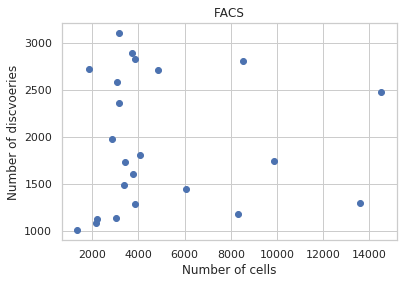

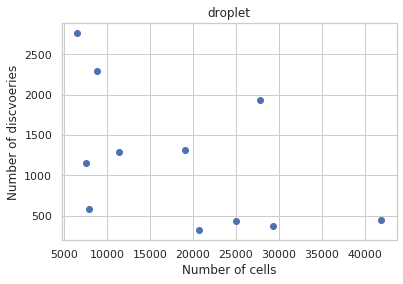

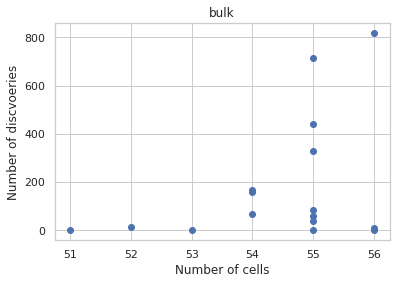

In [15]:
for method in method_list:
    df_analysis = dic_df_analysis[method]
    plt.figure()
    plt.scatter(df_analysis['n_cell_old'] + df_analysis['n_cell_young'],
                df_analysis['n_rej'])
    plt.xlabel('Number of cells')
    plt.ylabel('Number of discvoeries')
    plt.title(method)
    plt.show()

### Global aging genes

In [16]:
gene_name_list = list(temp_facs.var_names)
dic_df_raw_p = {}
dic_df_bh_p = {}
dic_df_fc = {}
for method in method_list:
    dic_df_raw_p[method] = pd.DataFrame(index = gene_name_list)
    dic_df_bh_p[method] = pd.DataFrame(index = gene_name_list)
    dic_df_fc[method] = pd.DataFrame(index = gene_name_list)
    for analyte in dic_analysis_list[method]:
        dic_df_raw_p[method][analyte] = dic_DE_result[method][analyte]['raw-p']
        dic_df_bh_p[method][analyte] = dic_DE_result[method][analyte]['bh-p']
        dic_df_fc[method][analyte] = dic_DE_result[method][analyte]['coef']

In [17]:
for method in method_list:
    dic_df_raw_p[method].to_csv(output_folder_tab + '/DGE_result.tissue.%s.raw_p.csv'%method)
    dic_df_bh_p[method].to_csv(output_folder_tab + '/DGE_result.tissue.%s.bh_p.csv'%method)
    dic_df_fc[method].to_csv(output_folder_tab + '/DGE_result.tissue.%s.age_coef.csv'%method)

In [18]:
dic_df_exp = {}
for method in ['FACS']:
    dic_df_exp[method] = pd.DataFrame(index = gene_name_list)
    for analyte in dic_analysis_list[method]:
        ind_select = (dic_data[method].obs['tissue'] == analyte)
        dic_df_exp[method][analyte] = \
            np.array(dic_data[method][ind_select].X.mean(axis=0)).reshape([-1])

In [19]:
dic_df_global_aging_gene = {}
for method in method_list:
    dic_df_global_aging_gene[method] = pd.DataFrame(index = gene_name_list)
    dic_df_global_aging_gene[method]['Prop. of Sig.'] = \
        ((dic_df_bh_p[method]<dic_fdr_threshold[method]) & 
         (np.absolute(dic_df_fc[method])>coef_threshold)).mean(axis=1)
    dic_df_global_aging_gene[method]['Prop. of +'] = (dic_df_fc[method]>coef_threshold).sum(axis=1) /\
                                            ((dic_df_fc[method]>coef_threshold) | 
                                             (dic_df_fc[method]<-coef_threshold)).sum(axis=1) 
    dic_df_global_aging_gene[method]['Median fc'] = dic_df_fc[method].median(axis=1)
    dic_df_global_aging_gene[method]['Median bh-p'] = dic_df_bh_p[method].median(axis=1)
    # result for each tissue
    for analyte in dic_analysis_list[method]:
        temp_df_bh_p_MAST = dic_df_bh_p[method][[analyte]]
        temp_df_fc_MAST = dic_df_fc[method][[analyte]]
        dic_df_global_aging_gene[method]['%s.Sig.'%(analyte)] = \
            1 * ((temp_df_bh_p_MAST<0.01) & (np.absolute(temp_df_fc_MAST)> coef_threshold))
        dic_df_global_aging_gene[method]['%s.Direction'%analyte] = \
            ((temp_df_fc_MAST > coef_threshold)*1 - (temp_df_fc_MAST < - coef_threshold)*1)

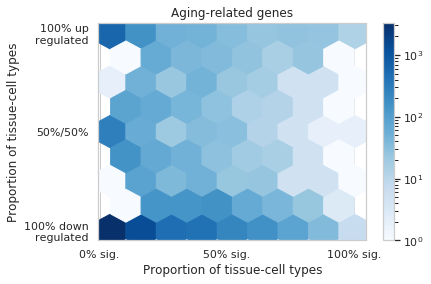

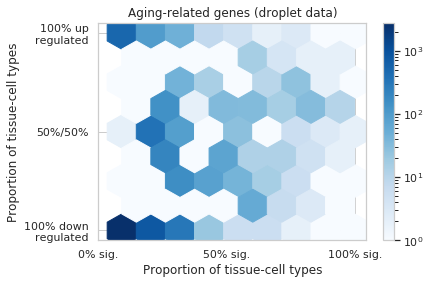

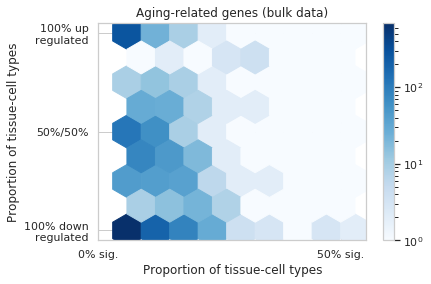

In [20]:
for method in method_list:
    ind_global = dic_df_global_aging_gene[method]['Prop. of Sig.']>0
    temp_df = dic_df_global_aging_gene[method].loc[ind_global]
    plt.figure(figsize=[6,4])
    plt.hexbin(temp_df['Prop. of Sig.'], temp_df['Prop. of +'], gridsize=8,
               cmap = 'Blues', bins='log')
    # plt.ylabel('Proportion of tissue-cell types \nwhere the gene is up-regulated')
    plt.ylabel('Proportion of tissue-cell types')
    # plt.xlabel('Proportion of tissue-cell types \nwhere the gene has a significant aging effect')
    plt.xlabel('Proportion of tissue-cell types')
    plt.colorbar()
    if method=='bulk':
        plt.xticks([0, 0.5], ['0% sig.', '50% sig.'])
    else:
        plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
    plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
    plt.title('Aging-related genes')
    if method=='droplet':
        plt.title('Aging-related genes (droplet data)')
    if method=='bulk':
        plt.title('Aging-related genes (bulk data)')
#     plt.ylabel('Proportion of tissues \n where the gene is up-regulated')
#     plt.xlabel('Proportion of tissues \n where the gene has a significant aging effect')
#     plt.colorbar()
#     plt.title(method)
    plt.savefig(output_folder_fig + '/tissue_global_aging_scatter_%s.pdf'%method,
                transparent=True, bbox_inches='tight')
    plt.show()

In [21]:
gene_name_list = np.array(dic_df_global_aging_gene['FACS'].index)
dic_global_aging_gene = {}
ind_global = dic_df_global_aging_gene['FACS']['Prop. of Sig.']>0.8
dic_global_aging_gene['all'] = (gene_name_list[ind_global]).tolist()
ind_select = ind_global & (dic_df_global_aging_gene['FACS']['Prop. of +']>0.8)
dic_global_aging_gene['up'] = gene_name_list[ind_select].tolist()
ind_select = ind_global & (dic_df_global_aging_gene['FACS']['Prop. of +']<0.2)
dic_global_aging_gene['down'] = gene_name_list[ind_select].tolist()
dic_global_aging_gene['other'] = list(set(gene_name_list[ind_global]) 
                                      - set(dic_global_aging_gene['up'])
                                      - set(dic_global_aging_gene['down']))
print('FACS, Total:%d, Up:%d, Down:%d, Other:%d'%(len(dic_global_aging_gene['all']),
                                            len(dic_global_aging_gene['up']), 
                                            len(dic_global_aging_gene['down']), 
                                            len(dic_global_aging_gene['other'])))

FACS, Total:131, Up:55, Down:60, Other:16


In [22]:
# Record all global aging genes
temp_df = dic_df_global_aging_gene['FACS'].copy()
temp_df = temp_df.loc[temp_df['Prop. of Sig.']>0.8]
temp_df = temp_df.sort_values(by='Prop. of Sig.', ascending=False)
temp_df = temp_df.iloc[:, 0:4]
temp_df['rank'] = np.arange(temp_df.shape[0])+1
temp_df.to_csv(output_folder_tab+'/tissue.global_aging.csv')
temp_df.to_excel(output_folder_tab+'/tissue.global_aging.xls')

### Heatmap of some interesting genes

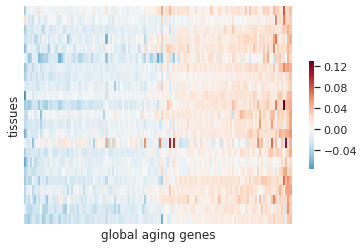

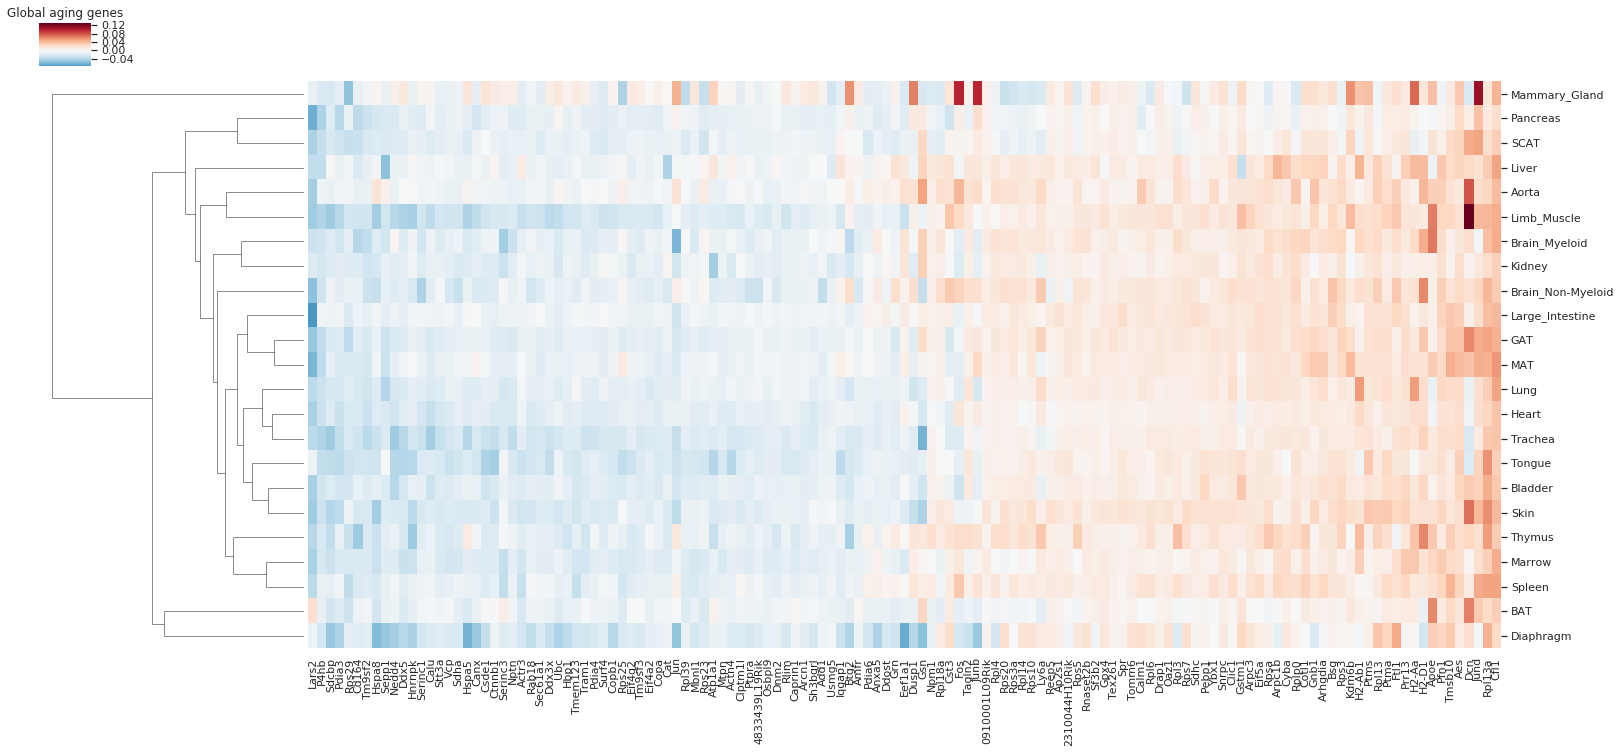

In [23]:
# Visualize global aging genes
method = 'FACS'
global_aging_gene_list = dic_global_aging_gene['all']
temp_df = dic_df_fc[method].loc[global_aging_gene_list]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.mean(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
# visualization: overview
sns.heatmap(temp_df, xticklabels=False, yticklabels=False,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.xlabel('global aging genes')
plt.ylabel('tissues')
plt.savefig(output_folder_fig + '/tissue_all_global_aging_gene_heatmap_small.pdf',
            transparent=True, bbox_inches='tight')
plt.show()
# visualization: whole
sns.clustermap(temp_df, xticklabels=True, yticklabels=True,
               row_cluster=True, metric='correlation', 
               col_cluster=False, 
               figsize = [0.2*temp_df.shape[1], 0.5*temp_df.shape[0]],
               cmap = 'RdBu_r', center=0)
plt.title('Global aging genes')
plt.savefig(output_folder_fig + '/tissue_all_global_aging_gene_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

### Aging score

In [24]:
# compute an aging score: facs
sc.tl.score_genes(temp_facs, gene_list = dic_global_aging_gene['up'], score_name='score_up',
                  random_state=1)
sc.tl.score_genes(temp_facs, gene_list = dic_global_aging_gene['down'], score_name='score_down',
                  random_state=1)
temp_facs.obs['score'] = temp_facs.obs['score_up'] - temp_facs.obs['score_down']
# compute an aging score: droplet
sc.tl.score_genes(temp_droplet, gene_list = dic_global_aging_gene['up'], score_name='score_up',
                  random_state=1)
sc.tl.score_genes(temp_droplet, gene_list = dic_global_aging_gene['down'], score_name='score_down',
                  random_state=1)
temp_droplet.obs['score'] = temp_droplet.obs['score_up'] - temp_droplet.obs['score_down']
# compute an aging score: bulk
sc.tl.score_genes(temp_bulk, gene_list = dic_global_aging_gene['up'], score_name='score_up',
                  random_state=1)
sc.tl.score_genes(temp_bulk, gene_list = dic_global_aging_gene['down'], score_name='score_down',
                  random_state=1)
temp_bulk.obs['score'] = temp_bulk.obs['score_up'] - temp_bulk.obs['score_down']

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [25]:
# Regress out sex and age
import statsmodels.formula.api as sm
# facs
temp_df_lr = temp_facs.obs.copy()
result = sm.ols(formula="score ~ age + sex + age*sex", data=temp_df_lr).fit()
temp_facs.obs['score_regout'] = result.resid
print(result.params)
# droplet
temp_df_lr = temp_droplet.obs.copy()
result = sm.ols(formula="score ~ age + sex + age*sex", data=temp_df_lr).fit()
temp_droplet.obs['score_regout'] = result.resid
print(result.params)
# bulk
temp_df_lr = temp_bulk.obs.copy()
result = sm.ols(formula="score ~ age + sex + age*sex", data=temp_df_lr).fit()
temp_bulk.obs['score_regout'] = result.resid
print(result.params)

Intercept                 0.763639
age[T.24m]                0.041115
age[T.3m]                -0.233240
sex[T.male]               0.109561
age[T.24m]:sex[T.male]    0.041115
age[T.3m]:sex[T.male]    -0.333662
dtype: float64
Intercept                 7.102526e-01
age[T.1m]                -1.121907e+06
age[T.21m]                4.031673e-02
age[T.24m]               -7.960504e+09
age[T.30m]               -2.675007e+09
age[T.3m]                 3.230860e-02
sex[T.male]              -2.283104e-02
age[T.1m]:sex[T.male]     1.121907e+06
age[T.21m]:sex[T.male]   -2.333044e-06
age[T.24m]:sex[T.male]    7.960504e+09
age[T.30m]:sex[T.male]    2.675007e+09
age[T.3m]:sex[T.male]    -2.641719e-02
dtype: float64
Intercept                -7.935150e-02
age[T.15m]               -2.333448e-03
age[T.18m]               -6.117254e-03
age[T.1m]                -1.701052e-02
age[T.21m]                4.725001e-03
age[T.24m]                1.056455e+12
age[T.27m]                6.002524e+10
age[T.3m]          

In [26]:
# facs
temp_df = temp_facs.obs.groupby(['sex', 'age', 'tissue']).\
            agg({'score':'mean', 'score_regout':'mean'})
temp_df = temp_df.loc[~np.isnan(temp_df['score'])]
temp_df.reset_index(inplace=True)  
# droplet
temp_df_droplet = temp_droplet.obs.groupby(['sex', 'age', 'tissue']).\
            agg({'score':'mean', 'score_regout':'mean'})
temp_df_droplet = temp_df_droplet.loc[~np.isnan(temp_df_droplet['score'])]
temp_df_droplet.reset_index(inplace=True) 
# bulk
temp_df_bulk = temp_bulk.obs.groupby(['sex', 'age', 'tissue']).\
            agg({'score':'mean', 'score_regout':'mean'})
temp_df_bulk = temp_df_bulk.loc[~np.isnan(temp_df_bulk['score'])]
temp_df_bulk.reset_index(inplace=True)  
# temp_df_bulk['mouse.id'] = temp_df_bulk['MouseID']

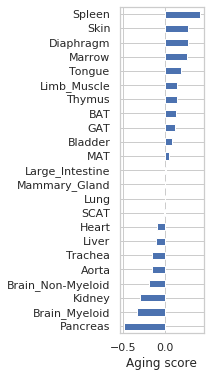

In [27]:
temp_plot = temp_facs.obs.groupby(['tissue']).agg({'score_regout':'mean'})
temp_plot = temp_plot.sort_values(by='score_regout')
temp_plot['aging_score'] = temp_plot['score_regout']
temp_plot.plot(y=['aging_score'], kind='barh', color=['C0'],
                 stacked=True, figsize=[1.5,6], legend=False)
plt.xlabel('Aging score')
plt.ylabel('')
plt.savefig(output_folder_fig + '/tissue_aging_score.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

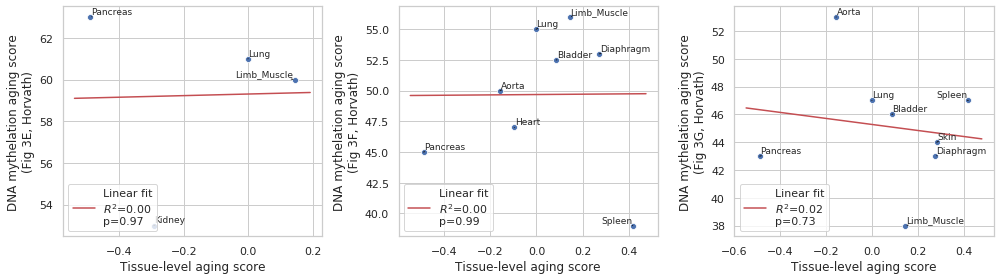

In [36]:
# Comparison with methylation age
df_mage = pd.read_csv(anno_data_folder + '/horvath_genome_biology_2013.csv', sep=',',
                      index_col=0)
df_mage = df_mage.join(temp_plot)
df_mage = df_mage.fillna(-1)
plt.figure(figsize=[14,4])
for i_y_term,y_term in enumerate(['E', 'F', 'G']):
# temp_mage_plot = temp_plot.copy().join(df_amge)
    plt.subplot(1,3,i_y_term+1)
    ind_select = (df_mage[[y_term, 'aging_score']]==-1).sum(axis=1)==0
    
    sns.scatterplot(x='aging_score', y=y_term,
                    data=df_mage.loc[ind_select])
    x_val = np.array(df_mage.loc[ind_select, 'aging_score'],
                     dtype=float)
    y_val = np.array(df_mage.loc[ind_select, y_term],
                     dtype=float)                                 
    sl, icpt, r_val, p_val, _ = sp.stats.linregress(x_val, y_val)
    # linear fit
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
             label='Linear fit\n$R^2$=%0.2f\np=%0.2f'%(r_val**2, p_val))
    plt.legend(loc='lower left')
    texts = []
    for tissue in df_mage.index[ind_select]:
        texts.append(plt.text(df_mage.loc[tissue, 'aging_score'],
                              df_mage.loc[tissue, y_term],
                              tissue, fontsize=9))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
    plt.xlabel('Tissue-level aging score')
    plt.ylabel('DNA mythelation aging score\n(Fig 3%s, Horvath)'%y_term)
    plt.tight_layout()
plt.savefig(output_folder_fig + '/tissue_aging_score_Horvath.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [37]:
output_folder_fig

'/data3/martin/tms_gene_data/results/tms_gene_figure'

In [29]:
# Comparison between different methods
tissue_list = list(set(temp_df['tissue']) | set(temp_df_droplet['tissue']) | 
                   set(temp_df_bulk['tissue']))
method_list = ['FACS', 'droplet', 'bulk']
temp_comparison = pd.DataFrame(index = tissue_list)
for method in method_list:
    temp_comparison['score_regout.%s'%(method)] = -1
    temp_comparison['n_cell.%s'%(method)] = -1
for tissue in temp_comparison.index:
    # FACS
    ind_select = (temp_facs.obs['tissue']==tissue)
    if np.sum(ind_select)>0:
        temp_comparison.loc[tissue, 'score_regout.FACS'] = \
            np.mean(temp_facs.obs['score_regout'][ind_select])
        temp_comparison.loc[tissue, 'n_cell.FACS'] = \
            np.sum(ind_select)
    # droplet
    ind_select = (temp_droplet.obs['tissue']==tissue)
    if np.sum(ind_select)>0:
        temp_comparison.loc[tissue, 'score_regout.droplet'] = \
            np.mean(temp_droplet.obs['score_regout'][ind_select])
        temp_comparison.loc[tissue, 'n_cell.droplet'] = \
            np.sum(ind_select)
    # bulk
    ind_select = (temp_bulk.obs['tissue']==tissue)
    if np.sum(ind_select)>0:
        temp_comparison.loc[tissue, 'score_regout.bulk'] = \
            np.mean(temp_bulk.obs['score_regout'][ind_select])
        temp_comparison.loc[tissue, 'n_cell.bulk'] = \
            np.sum(ind_select)

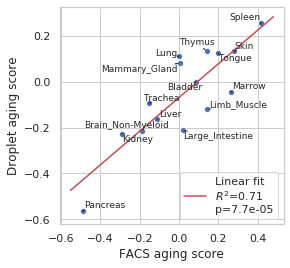

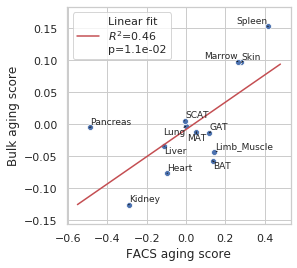

In [30]:
comparison_list = ['FACS;droplet', 'FACS;bulk']
for comparison in comparison_list:
    method1,method2 = comparison.split(';')
    ind_select = (temp_comparison[['score_regout.%s'%(method1),
                                   'score_regout.%s'%(method2)]]==-1).sum(axis=1)==0
    plt.figure(figsize=[4,4])
    sns.scatterplot(x='score_regout.%s'%(method1), y='score_regout.%s'%(method2),
                    data=temp_comparison.loc[ind_select])
    x_val = np.array(temp_comparison.loc[ind_select, 'score_regout.%s'%(method1)],
                     dtype=float)
    y_val = np.array(temp_comparison.loc[ind_select, 'score_regout.%s'%(method2)],
                     dtype=float)                                 
    sl, icpt, r_val, p_val, _ = sp.stats.linregress(x_val, y_val)
    # linear fit
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
             label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
    if method2=='droplet':
        plt.legend(loc='lower right')
    else:
        plt.legend(loc='upper left')
    texts = []
    for tissue in temp_comparison.index[ind_select]:
        texts.append(plt.text(temp_comparison.loc[tissue, 'score_regout.%s'%(method1)],
                              temp_comparison.loc[tissue, 'score_regout.%s'%(method2)],
                              tissue, fontsize=9))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
    plt.xlabel('%s aging score'%method1)
    if method2=='droplet':
        plt.ylabel('Droplet aging score')
    elif method2=='bulk':
        plt.ylabel('Bulk aging score')
    plt.savefig(output_folder_fig + '/tissue_aging_score_%s_%s.pdf'%(method1, method2),
                transparent=True, bbox_inches='tight')
    plt.show()

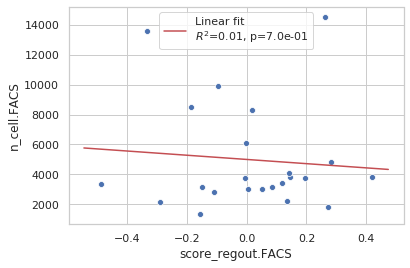

In [31]:
ind_select = temp_comparison['score_regout.FACS']>-1
sns.scatterplot(x = 'score_regout.FACS', y='n_cell.FACS',
                data=temp_comparison.loc[ind_select])
x_val = np.array(temp_comparison.loc[ind_select, 'score_regout.FACS'], dtype=float)
y_val = np.array(temp_comparison.loc[ind_select, 'n_cell.FACS'], dtype=float)                                 
sl, icpt, r_val, p_val, _ = sp.stats.linregress(x_val, y_val)
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f, p=%0.1e'%(r_val**2, p_val))
plt.legend()
plt.show()

In [32]:
output_folder_fig

'/data3/martin/tms_gene_data/results/tms_gene_figure'